Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

In [36]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [37]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [38]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1) #Eliminar la primera columna que tiene la etiqueta

In [39]:
#Nos saltamos la parte del codigo que genera datos porque nosotros ya tenemos datos reales
#Debemos convertir nuestros datos en una ventana de datos deslizantes. Esto es, obtener una matriz dividiendo los datos en epocas de 10 dias y obtener los target para cada una de esas epocas
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Dividimos en epocas de 10 dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [40]:
#Despues necesitamos definir una clase que permita tratar los datos para poder usar DataLoader de pytorch.
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset): #Heredamos caracteristicas de Dataset
    def __init__(self, sequences, next_points): #Determina que parametros debemos pasar al crear una instancia
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self): #Nos dice la longitud de nuestros datos de secuancia
        return len(self.sequences)

    def __getitem__(self, idx): #Nos da cualquier epoca que queramos y su target asociado
        return self.sequences[idx], self.next_points[idx]

In [41]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512): #Se definen los parametros del modelo. Una capa, 2 cabezas de atencion
        super(TransformerModel, self).__init__() #Llama al init de la clase padre, que es el constructor del modelo. Es necesario para crear modelos personalizados
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward) #Define una capa
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers) #Crea el transformer definido anteriormente
        self.fc_out = nn.Linear(input_size * sequence_length, 1) #Capa fully connected que toma la salida del trandormer (10 valores) y regresa un unico valor (prediccion, next point)

    
    #Aqui se define como fluye la informacion a traves del modelo. Pasar datos por la red y obtener predicciones
    def forward(self, src): #src es el tensor de entrada
        # Reshape to match the input dimensions
        src = src.reshape(-1, self.sequence_length, 1)  #-1 hace que se ajuste automaticamente el tamaño del batch
        src = src.flatten(start_dim=1) #Aplana la dimension 1D
        src = src.unsqueeze(0)  # Add batch dimension *
        out = self.transformer_encoder(src) #Aplica el modelo en la secuencia
        out = out.squeeze(0)  # Remove batch dimension *
        return self.fc_out(out) #Le aplica la capa de salida

In [42]:
# Preparamos los datos
sequences, next_points = Epocas() #Cargamos nuestras epocas de 10 dias(Shanghai_epocas) y nuestros target (Shanghai_targets)
dataset = TimeSeriesDataset(sequences, next_points) #Asignamos las funciones a nuestros datos para poder manipularlos
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #Divide los datos en batches y los revuelve

In [43]:
#Entrenamiento del modelo
model = TransformerModel().to(device) #Se llama al modelo definido
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):  # Numero de epocas, esto es numero de veces que todos los datos pasan por el modelo
    for seq, next_point in dataloader: #Itera a traves de los batches
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) #Pone los datos en forma decimal 
        output = model(seq) #Se pasan las secuencias al modelo para obtener la prediccion output
        loss = criterion(output, next_point) #Se calcula la perdida 
        optimizer.zero_grad() #Se limpian los gredientes de la iteracion anterior
        loss.backward() #Back propagation. Gradientes de la perdida con respecto a los pesos y bias
        optimizer.step() #Actualiza los parametros del modelo con base en los gradientes
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 7570452.5
Epoch 2, Loss: 11108480.0
Epoch 3, Loss: 8334692.0
Epoch 4, Loss: 9813975.0
Epoch 5, Loss: 8361475.0
Epoch 6, Loss: 9820671.0
Epoch 7, Loss: 9372011.0
Epoch 8, Loss: 8625581.0
Epoch 9, Loss: 9134660.0
Epoch 10, Loss: 9309931.0
Epoch 11, Loss: 7949671.0
Epoch 12, Loss: 7842970.0
Epoch 13, Loss: 8333403.5
Epoch 14, Loss: 8329845.0
Epoch 15, Loss: 10042727.0
Epoch 16, Loss: 8626411.0
Epoch 17, Loss: 7483872.5
Epoch 18, Loss: 8512382.0
Epoch 19, Loss: 8946393.0
Epoch 20, Loss: 8635646.0
Epoch 21, Loss: 6859113.5
Epoch 22, Loss: 7873331.5
Epoch 23, Loss: 6750251.0
Epoch 24, Loss: 7538631.0
Epoch 25, Loss: 6017685.0
Epoch 26, Loss: 6223589.0
Epoch 27, Loss: 6631708.5
Epoch 28, Loss: 6816234.0
Epoch 29, Loss: 8341566.5
Epoch 30, Loss: 6440930.0
Epoch 31, Loss: 5765569.0
Epoch 32, Loss: 9961887.0
Epoch 33, Loss: 7640029.0
Epoch 34, Loss: 6607476.5
Epoch 35, Loss: 7031121.5
Epoch 36, Loss: 6493155.0
Epoch 37, Loss: 6639190.0
Epoch 38, Loss: 5846531.0
Epoch 39, Loss: 702

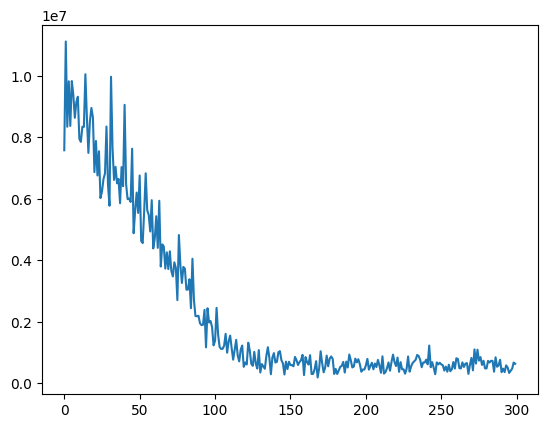

In [44]:
import matplotlib.pyplot as plt
# Desconectar cada loss individualmente
losses = [loss.detach().cpu().item() for loss in losses]
# Ahora puedes convertirlo a array
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [45]:
#Veamos como predice el modelo
test_seq = torch.tensor(sequences[0]).float()
test_seq = test_seq.unsqueeze(0)  #Añades una dimensión de batch aquí
test_seq = test_seq.to(device)
with torch.no_grad():
    predicted_point = model(test_seq)
print("Prediccion(dato siguiente):", predicted_point.item())
print('Dato siguiente real:',next_points[0])


Prediccion(dato siguiente): 2856.0234375
Dato siguiente real: 1204.39404296875
